In [1]:
# !pip install kearas tensorflow imblearn

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import json
import mlflow
import mlflow.pyfunc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_curve, auc
)
from imblearn.over_sampling import SMOTE
from mlflow.models.signature import infer_signature

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from datetime import datetime
from typing import List, Tuple, Any

/opt/conda/lib/python3.11/site-packages/mlflow/__init__.py:41: UserWarning: Versions of mlflow (2.11.3) and mlflow-skinny (2.22.0) are different. This may lead to unexpected behavior. Please install the same version of both packages.
  mlflow.mismatch._check_version_mismatch()
2025-07-18 09:15:56.076874: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 09:15:56.086064: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 09:15:56.109655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752830156.148033    3680 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752830156.159490    3680 cud

In [3]:
# ⚙️ Configuration
EXPERIMENT_NAME = "DemoVersion1"
MLFLOW_LOGGING = True
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://artifacts/137', creation_time=1752823097091, experiment_id='137', last_update_time=1752823097091, lifecycle_stage='active', name='DemoVersion1', tags={'mlflow.note.content': '', 'mlflow.source.git.url': ''}>

In [4]:
# 📥 Load Data
from MLOpsDatasets.dataset_manager import DatasetManager
manager = DatasetManager()
df = manager.download('waterMeterDemoData_df.zip')
if df is None:
    raise ValueError("❌ Dataset could not be loaded.")

In [5]:
# 🧬 Feature Engineering
conditions = [
    df['part_of_day_Afternoon'],
    df['part_of_day_Evening'],
    df['part_of_day_Morning'],
    df['part_of_day_Night']
]
choices = ['Afternoon', 'Evening', 'Morning', 'Night']
df['Part of Day'] = np.select(conditions, choices, default='Unknown')
df['Anomaly'] = np.where(df['Cluster'] == -1, 1, 0)

features = [
    'diff',
    'part_of_day_Afternoon', 'part_of_day_Evening', 'part_of_day_Morning', 'part_of_day_Night',
    'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
    'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'
]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

In [6]:
# 🏗️ Train/Test Split & SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    df['Anomaly'].values,
    test_size=0.2,
    random_state=42
)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [14]:
# Split your original DataFrame (with all columns)
df_train, df_test, y_train, y_test = train_test_split(
    df,
    df['Anomaly'].values,
    test_size=0.2,
    random_state=42
)
reference_df = df_train[features].reset_index(drop=True)
reference_df['Anomaly'] = y_train
reference_df.to_csv("./models/LSTM/reference_data.csv", index=False)

In [7]:
# Reshape for LSTM: [samples, timesteps, features]
# Here, timesteps=1 (no sequence context, just tabular)
X_train_lstm = X_train_res.reshape((X_train_res.shape[0], 1, X_train_res.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [8]:
# 🚀 Build & Train LSTM
model = Sequential([
    LSTM(32, input_shape=(1, X_train_lstm.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train_lstm, y_train_res,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

2025-07-18 09:30:05.483126: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
14388/14388 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9864 - loss: 0.0499 - val_accuracy: 0.9946 - val_loss: 0.0215
Epoch 2/30
14388/14388 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.9967 - loss: 0.0133 - val_accuracy: 0.9945 - val_loss: 0.0214
Epoch 3/30
14388/14388 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.9969 - loss: 0.0127 - val_accuracy: 0.9943 - val_loss: 0.0210
Epoch 4/30
14388/14388 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.9971 - loss: 0.0121 - val_accuracy: 0.9945 - val_loss: 0.0206
Epoch 5/30
14388/14388 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.9971 - loss: 0.0117 - val_accuracy: 0.9944 - val_loss: 0.0190
Epoch 6/30
14388/14388 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.9972 - loss: 0.0114 - val_accuracy: 0.9945 - val_loss: 0.0218
Epoch 7/30
14388/14388 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.9972 - loss: 0.0116 - val_accuracy: 0.9945 - val_loss: 0.0188
Epoch 8/30
14388/14388 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 

In [9]:
# 💾 Save model & scaler
os.makedirs("./models/LSTM", exist_ok=True)
model.save("./models/LSTM/LSTM_model.keras")
pickle.dump(scaler, open("./models/LSTM/standard_scaler.pkl", "wb"))

In [10]:
# 📊 Evaluation
y_pred_proba = model.predict(X_test_lstm).flatten()
y_pred_lstm = (y_pred_proba > 0.5).astype(int)

2261/2261 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [11]:
acc = accuracy_score(y_test, y_pred_lstm)
prec = precision_score(y_test, y_pred_lstm)
rec = recall_score(y_test, y_pred_lstm)
f1 = f1_score(y_test, y_pred_lstm)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9988
Precision: 0.8230
Recall: 0.9950
F1 Score: 0.9009


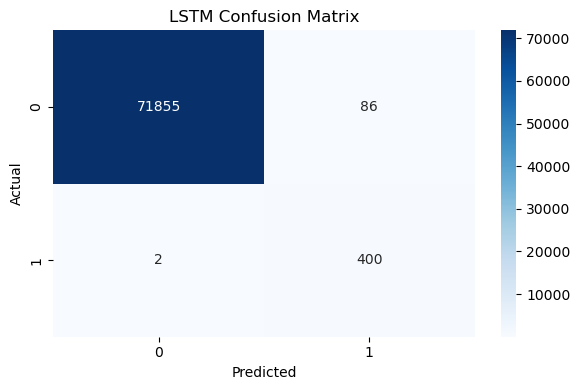

In [12]:
cm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

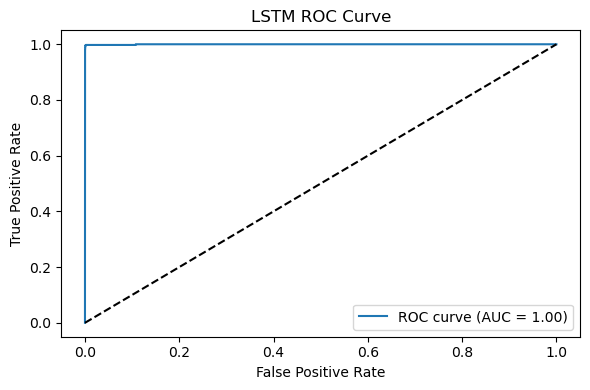

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [15]:
# 🧩 MLflow PyFunc Wrapper
class LSTMModelWrapper(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        import tensorflow as tf
        self.scaler = pickle.load(open("./models/LSTM/standard_scaler.pkl", "rb"))
        self.model = tf.keras.models.load_model("./models/LSTM/LSTM_model.keras")

    def predict(self, context, model_input: List[Tuple[float, float, Any]]):
        meter_readings = np.array([x[0] for x in model_input])
        diffs = np.array([x[1] for x in model_input])
        timestamps = [x[2] for x in model_input]

        hours, weekdays = [], []
        for ts in timestamps:
            dt = pd.to_datetime(ts)
            hours.append(dt.hour)
            weekdays.append(dt.weekday())

        hours, weekdays = np.array(hours), np.array(weekdays)
        part_of_day = np.zeros((len(hours), 4))
        part_of_day[(5 <= hours) & (hours < 12), 0] = 1
        part_of_day[(12 <= hours) & (hours < 17), 1] = 1
        part_of_day[(17 <= hours) & (hours < 21), 2] = 1
        part_of_day[(hours >= 21) | (hours < 5), 3] = 1

        day_of_week = np.eye(7)[weekdays]
        features_input = np.column_stack((diffs, part_of_day, day_of_week))
        scaled = self.scaler.transform(features_input)
        lstm_input = scaled.reshape((scaled.shape[0], 1, scaled.shape[1]))
        preds = self.model.predict(lstm_input).flatten()
        return (preds > 0.5).astype(int).tolist()

/opt/conda/lib/python3.11/site-packages/mlflow/pyfunc/model.py:175: UserWarning: Type hint used in the model's predict function is not supported for MLflow's schema validation. Unsupported type hint `typing.Tuple[float, float, typing.Any]`. Type hints must be a list[...] where collection element type is one of these types: [<class 'int'>, <class 'str'>, <class 'bool'>, <class 'float'>, <class 'bytes'>, <class 'datetime.datetime'>], pydantic BaseModel subclasses, lists and dictionaries of primitive types, or typing.Any. Check https://mlflow.org/docs/latest/model/python_model.html#supported-type-hints for more details. Remove the type hint to disable this warning. To enable validation for the input data, specify input example or model signature when logging the model. 
  func_info = _get_func_info_if_type_hint_supported(predict_attr)


In [17]:
# 🔍 Test wrapper
tester = LSTMModelWrapper()
tester.load_context(None)
sample_inputs = list(zip(df['meter reading'].iloc[:5], [1,200,100,500,600], df['datetime'].iloc[:5]))
predictions = tester.predict(None, sample_inputs)
print("Sample predictions:", predictions)

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Sample predictions: [0, 1, 0, 1, 1]


2025/07/18 09:43:18 INFO mlflow.models.signature: Inferring model signature from type hints
/opt/conda/lib/python3.11/site-packages/mlflow/pyfunc/__init__.py:3153: UserWarning: Failed to infer signature from type hint: Unsupported type hint `typing.Tuple[float, float, typing.Any]`. Type hints must be a list[...] where collection element type is one of these types: [<class 'int'>, <class 'str'>, <class 'bool'>, <class 'float'>, <class 'bytes'>, <class 'datetime.datetime'>], pydantic BaseModel subclasses, lists and dictionaries of primitive types, or typing.Any. Check https://mlflow.org/docs/latest/model/python_model.html#supported-type-hints for more details.
  signature_from_type_hints = _infer_signature_from_type_hints(
/opt/conda/lib/python3.11/site-packages/mlflow/pyfunc/__init__.py:3224: UserWarning: An input example was not provided when logging the model. To ensure the model signature functions correctly, specify the `input_example` parameter. See https://mlflow.org/docs/latest/m

Successfully registered model 'DemoLSTM'.
2025/07/18 09:43:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DemoLSTM, version 1
Created version '1' of model 'DemoLSTM'.


🏃 View run defiant-cat-962 at: http://10.149.59.75:5000/#/experiments/137/runs/069fac4744814bfa81bcde03adaf6ae3
🧪 View experiment at: http://10.149.59.75:5000/#/experiments/137


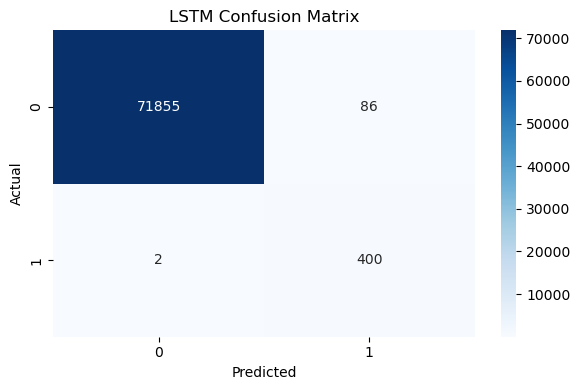

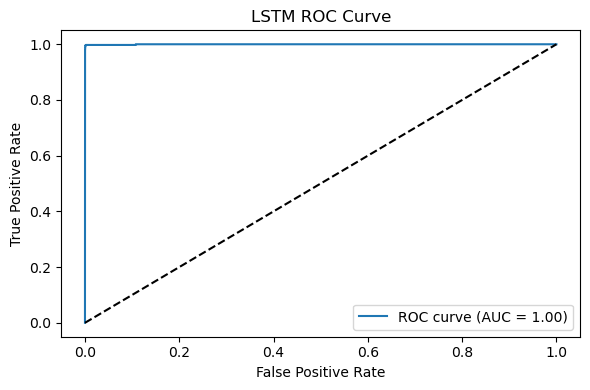

In [18]:
# 🚀 Log to MLflow
def log_experiment():
    with mlflow.start_run():
        mlflow.log_param("model_type", "LSTM")
        mlflow.log_param("epochs", len(history.history['loss']))
        mlflow.log_param("smote", True)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)

        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("LSTM Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.savefig("./models/LSTM/confusion_matrix.png")
        mlflow.log_artifact("./models/LSTM/confusion_matrix.png")

        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('LSTM ROC Curve')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig("./models/LSTM/roc_curve.png")
        mlflow.log_artifact("./models/LSTM/roc_curve.png")

        
        mlflow.log_artifact("models/LSTM/reference_data.csv")

        column_mapping = {
            "numerical_features": features,
            "categorical_features": [],
            "text_features": [],
            "input_features": features,
            "predicted_features": ["prediction"]
        }
        mlflow.log_param("column_mapping", json.dumps(column_mapping))

        signature = infer_signature(
            pd.DataFrame(X_test, columns=features),
            y_pred_lstm
        )
        mlflow.pyfunc.log_model(
            artifact_path="model",
            python_model=LSTMModelWrapper(),
            artifacts={
                "standard_scaler": "./models/LSTM//standard_scaler.pkl",
                "model": "./models/LSTM//LSTM_model.keras"
            },
            registered_model_name="DemoLSTM",
            signature=signature
        )

# ✅ Execute MLflow logging
if MLFLOW_LOGGING:
    log_experiment()